In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV

In [2]:
d_name = "espresso_data"

In [3]:
def get_curves(dir_name):
    all_bt = []
    all_et = []
    all_burner = []
    
    file_names = os.listdir(dir_name)
    
    for i,f_name in enumerate(file_names):
        bt_curve = extract_curve(f_name,dir_name,"'temp2':")
        et_curve = extract_curve(f_name,dir_name,"'temp1':")
        burner_curve = extract_burner(f_name,dir_name)
        
        if not bt_curve == []:
            all_bt.append(bt_curve)
        if not et_curve == []:
            all_et.append(et_curve)
        if not burner_curve == []:
            all_burner.append(burner_curve)
            
    return all_bt,all_et,all_burner

def extract_burner(f_name,dir_name):
    events = []
    events_types = []
    events_value = []
    burner_curve = []
    
    with open(dir_name+"/"+f_name,"r") as f:
        lines = [
        line.strip("\n").split(" ") + [index + 1]
        for index, line in enumerate(f.readlines())
        ]
        if len(lines)==0:
            return []
        lines = lines[0]
        
        charge_idx = get_charge(lines)
        drop_index = int(float(lines[lines.index("'DROP_time':")+1][:-1]))
        
        events_idx = lines.index("'specialevents':")
        event_types_idx = lines.index("'specialeventstype':")
        events_value_idx = lines.index("'specialeventsvalue':")
        n_events = event_types_idx - events_idx - 1
        for i in range(events_idx+1,event_types_idx):
            e = lines[i][:-1]
            if i == events_idx + 1:
                e = e[1:]
            elif i == event_types_idx - 1:
                e = e[:-1]

            events.append(float(e))

        for i in range(event_types_idx+1,event_types_idx+1+n_events):
            e = lines[i][:-1]
            if i == event_types_idx+1:
                e = e[1:]
            elif i == event_types_idx + n_events:
                e = e[:-1]

            events_types.append(int(e))
        
        for i in range(events_value_idx+1,events_value_idx+1+n_events):
            e = lines[i][:-1]
            if i == events_value_idx+1:
                e = e[1:]
            elif i == events_value_idx + n_events:
                e = e[:-1]
            
            events_value.append(float(e))
            
    for i,e in  enumerate(events_value):
        if(events_types[i]==3):
                if i == len(events)-1:
                    while len(burner_curve)<=drop_index:
                        burner_curve.append(e)
                else:
                    for j in range(int(events[i]-(0 if i==0 else events[i-1]))):
                        if j + (0 if i==0 else events[i-1]) >= charge_idx:
                            burner_curve.append(e)
    return burner_curve   
            
def extract_curve(f_name,dir_name,curve_name):
    curve = []
    with open(dir_name+"/"+f_name,"r") as f:
            lines = [
            line.strip("\n").split(" ") + [index + 1]
            for index, line in enumerate(f.readlines())
            ]
            if len(lines)==0:
                return []
            lines = lines[0]

            #calculate indexes of CHARGE and DROP with regard to reading points, to extract temp readings only during roast
            charge_index = get_charge(lines)
            drop_index = int(float(lines[lines.index("'DROP_time':")+1][:-1]))+charge_index
            
            #shift indexes to correspond to proper place in the file
            curve_index = lines.index(curve_name)
            charge_index += curve_index+1
            drop_index += curve_index+1
            
            current_index = charge_index
            while current_index <= drop_index:
                curve.append(float(lines[current_index][:-1]))
                current_index += 1
    
    #mapping to get rid 
    return curve
        
def get_charge(lines):
    # find TP info to derive CHARGE index
    tp_info_index = lines.index("'TP_idx':")
    TP_idx = lines[tp_info_index+1]
    TP_time = lines[tp_info_index+3]
    
    #get rid of coma and cast to int
    TP_idx = int(float(TP_idx[:-1]))
    TP_time = int(float(TP_time[:-1]))
    
    # CHARGE IS TP_time seconds before TP_idx
    # could include time_step info as we assume that each step is 1s which sometimes might not be the case
    CHARGE_idx = TP_idx - TP_time
    
    return CHARGE_idx
        

In [4]:
bt_list,et_list,burner_list = get_curves(d_name)

data = []
for i in range(len(bt_list)):
    triple_curve = [bt_list[i],et_list[i],burner_list[i]]
    #triple_curve = bt_list[i]
    triple_curve = [list(x) for x in zip(*triple_curve)]
    data.append(triple_curve)
n_features = 3

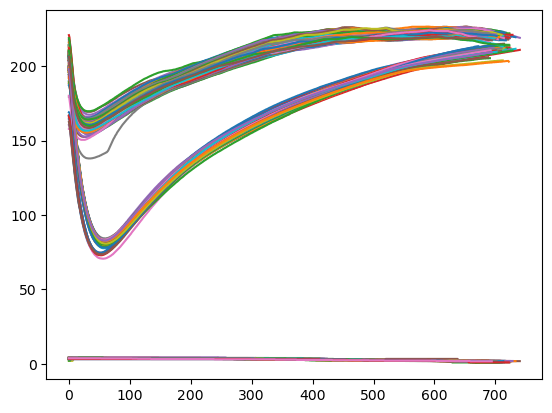

In [5]:

#for i in (range(len(data))):
for c in data:
    plt.plot(c)

In [6]:
input_sequence_length = 60
output_sequence_length = 120

# Assuming you have data in the format: [bean_temperature, air_temperature]

# Modify data preparation
X_data = []
y_data = []

for curve in data:
    for i in range(len(curve) - input_sequence_length - output_sequence_length + 1):
        X_data.append(curve[i:i+input_sequence_length][:])  # Use both bean and air temperatures as input
        y_data.append(curve[i+input_sequence_length:i+input_sequence_length+output_sequence_length][:])  # Predict only bean temperature

X_data = np.array(X_data)
y_data = np.array(y_data)

scaler = MinMaxScaler()
X_data_scaled = scaler.fit_transform(X_data.reshape(-1, n_features)).reshape(X_data.shape)  # Use 2 features for scaling
y_data_scaled = scaler.transform(y_data.reshape(-1, n_features)).reshape(y_data.shape)[:,:,0]

In [ ]:
# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(units=60, activation='relu', input_shape=(input_sequence_length, n_features), return_sequences=True),
    layers.LSTM(units=30, activation='relu',return_sequences=True),
    layers.LSTM(units=15, activation='relu'),
    layers.Dense(units=output_sequence_length)
])
# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_data_scaled, y_data_scaled, epochs=40, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/40
1376/2485 [===============>..............] - ETA: 34s - loss: 0.0998

1/1 [==============================] - 0s 71ms/step
Predicted Sequence:
[159.25713785 159.77155067 159.798185   160.71393139 160.01461513
 160.93294449 161.41439832 160.98701782 161.19407363 160.99536217
 161.68499835 161.61931373 162.18727685 161.78262807 162.79482133
 163.07930179 162.36575104 163.0720035  163.29676188 164.38417501
 164.47385467 164.54280622 164.09217097 164.72948797 164.49694849
 165.19665904 165.42397625 165.67070998 165.3539706  165.50498165
 166.05684347 166.12556167 166.47363461 167.12647356 167.12220885
 166.50987662 167.75117345 167.31523134 167.58713491 168.13111104
 168.76317359 168.32686133 168.03031899 168.8542775  168.61338563
 168.80790479 169.23321731 169.24442626 169.62682612 170.16795374
 170.56474097 169.92115564 170.02414442 170.56731589 171.25536687
 171.25198729 171.37270279 171.2128485  171.48352094 171.75097473
 171.96783937 172.24550433 171.83721043 172.04238333 172.43567832
 172.82725133 173.09207387 173.06514181 173.20765562 173.58377106
 174

<Axes: >

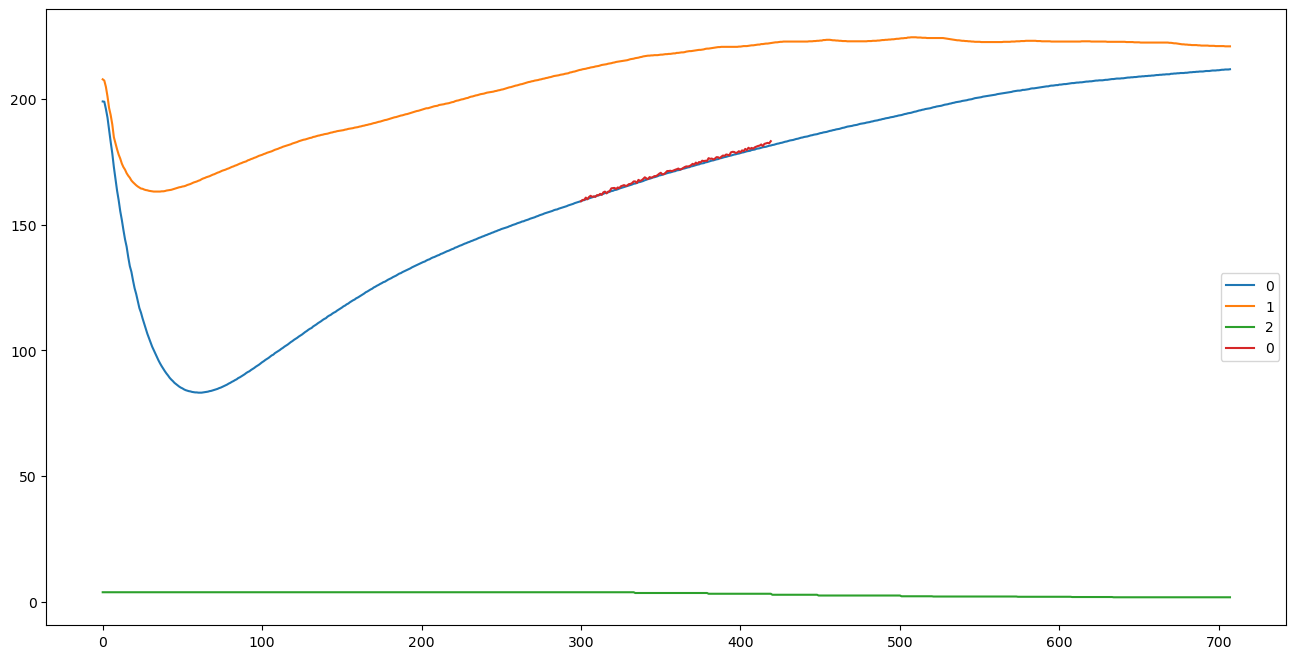

In [12]:
curve_id = 170
offset = 240
mock_X = np.array([np.arange(output_sequence_length),np.arange(output_sequence_length)])
mock_X = mock_X.reshape(2,output_sequence_length)
X_new = data[curve_id][offset:offset+input_sequence_length]
X_new = np.array(X_new)
X_new = X_new.reshape(input_sequence_length,n_features)
X_new_scaled = scaler.transform(X_new.reshape(-1, n_features)).reshape(1, input_sequence_length, n_features)
predictions_scaled = model.predict(X_new_scaled)
# Inverse transform the predictions to the original scale
predictions_scaled = predictions_scaled.reshape(1,output_sequence_length)
predictions_scaled = np.append(predictions_scaled,mock_X,axis=0)
predictions_scaled = np.transpose(predictions_scaled)
predictions = scaler.inverse_transform(predictions_scaled)
predictions = predictions[:,0]


# Print the predicted sequence
print("Predicted Sequence:")
print(predictions.squeeze())

df = pd.DataFrame(data[curve_id])
pred_index = np.arange(offset+input_sequence_length,input_sequence_length+len(predictions)+offset,1)
pred_df = pd.DataFrame(data=predictions,index=pred_index)
#Plot predictions vs real curve
ax = df.plot(figsize=(16,8))
pred_df.plot(ax=ax)

In [119]:
losses = pd.DataFrame(model.history.history)
losses


""


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have data in the format: [bean_temperature, air_temperature]

# Modify data preparation
X_data = []
y_data = []

for curve in data:
    for i in range(len(curve) - input_sequence_length - output_sequence_length + 1):
        X_data.append(curve[i:i+input_sequence_length][:])  # Use both bean and air temperatures as input
        y_data.append(curve[i+input_sequence_length:i+input_sequence_length+output_sequence_length][:])  # Predict only bean temperature

X_data = np.array(X_data)
y_data = np.array(y_data)

scaler = MinMaxScaler()
X_data_scaled = scaler.fit_transform(X_data.reshape(-1, n_features)).reshape(X_data.shape)  # Use 2 features for scaling
y_data_scaled = scaler.transform(y_data.reshape(-1, n_features)).reshape(y_data.shape)[:,:,0]

# Define the LSTM model as a function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
                          activation='relu',
                          input_shape=(input_sequence_length, n_features),
                          return_sequences=True))
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
                          activation='relu'))
    model.add(layers.Dense(output_sequence_length))

    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # you can increase this number for a more exhaustive search
    executions_per_trial=1,
    directory='my_dir',
    project_name='bean_temperature_prediction')

# Search for the best hyperparameters
tuner.search(X_data_scaled, y_data_scaled, epochs=40, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
model.fit(X_data_scaled, y_data_scaled, epochs=40, batch_size=32, validation_split=0.2)

Trial 1 Complete [22h 02m 58s]
val_loss: 4.4570020691026e-05

Best val_loss So Far: 4.4570020691026e-05
Total elapsed time: 22h 02m 58s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
160               |224               |units
0.001             |0.0001            |learning_rate

Epoch 1/40
2485/2485 [==============================] - 481s 193ms/step - loss: 0.0032 - val_loss: 6.3910e-05
Epoch 2/40
2485/2485 [==============================] - 434s 175ms/step - loss: 5.0334e-05 - val_loss: 2.2169e-04
Epoch 3/40
2485/2485 [==============================] - 436s 176ms/step - loss: 4.8466e-05 - val_loss: 4.1459e-05
Epoch 4/40
1842/2485 [=====================>........] - ETA: 1:46 - loss: 3.6743e-05

In [120]:
model.save("128n-2layer-lstm-rly-good.keras")

In [6]:
model = keras.models.load_model('128n-2layer-lstm-rly-good.keras')